In [1]:
%reset -f

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from sklearn.metrics import f1_score, recall_score, precision_score, cohen_kappa_score
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import io  # for reading TIFF images
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


2025-05-14 14:54:38.559990: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 14:54:38.804108: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-14 14:54:38.804176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-14 14:54:38.835220: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 14:54:38.907460: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
# Set the desired number of patches
desired_num_patches = 15000

# Your data directories
optic_images_dir = 'Sentinel-2-patches/'
sar_images_dir = 'Sentinel-1-patches/'
agb_maps_dir = 'AGB_Patches/AGB_Patches'

# Get the list of file names in the directories without sorting
agb_map_files = os.listdir(agb_maps_dir)
optic_image_files = os.listdir(optic_images_dir)
sar_image_files = os.listdir(sar_images_dir)

# Initialize empty lists to store data
x_train_list = []
y_train_list = []
agb_values_list = []

# Loop through each patch with tqdm for progress bars
# Loop through each patch with tqdm for progress bars
for i in tqdm(range(desired_num_patches), desc='Loading Patches'):
    # Get file names for the current index
    optic_file = optic_image_files[i]
    sar_file = sar_image_files[i]
    agb_file = agb_map_files[i]
    # Load images
    optic_image = io.imread(os.path.join(optic_images_dir, optic_file))
    sar_image = io.imread(os.path.join(sar_images_dir, sar_file))
    agb_map = io.imread(os.path.join(agb_maps_dir, agb_file))

    # Save AGB values as a NumPy array
    agb_values_list.append(agb_map.flatten())

    # Ensure optic image has 13 bands
    if optic_image.shape[-1] == 13:
        x_train = optic_image
    else:
        raise ValueError("Optic image should have 13 bands. Found: {}".format(optic_image.shape[-1]))

    # Check if SAR image has 2 bands
    if len(sar_image.shape) == 2:
        # Expand dimensions to make it 3D
        sar_image = np.stack([sar_image, sar_image], axis=-1)

    # Normalize the data using min-max scaling
    optic_image_normalized = (optic_image - np.min(optic_image)) / (np.max(optic_image) - np.min(optic_image))
    sar_image_normalized = (sar_image - np.min(sar_image)) / (np.max(sar_image) - np.min(sar_image))

    # Concatenate optic and SAR images
    x_train = np.concatenate([optic_image_normalized, sar_image_normalized], axis=-1)

    x_train_list.append(x_train)

    # Break the loop when desired_num_patches is reached
    if len(x_train_list) >= desired_num_patches:
        break

# Combine all patches into single arrays
x_data = np.stack(x_train_list)
agb_values = np.concatenate(agb_values_list)

# Normalize AGB values using min-max scaling
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
agb_scaled = (agb_values - min_agb) / (max_agb - min_agb)

# Reshape scaled AGB values for compatibility with the model
agb_normalized = np.expand_dims(agb_scaled, axis=-1)

# Split the data into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, agb_normalized, test_size=0.20, random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
input_shape = x_train.shape[1:]

Loading Patches: 100%|█████████▉| 9999/10000 [00:19<00:00, 501.94it/s]


x_train: (6400, 90, 90, 15)
y_train: (6400, 1)
x_val shape: (1600, 90, 90, 15)
y_val shape: (1600, 1)
x_test shape: (2000, 90, 90, 15)
y_test shape: (2000, 1)


In [ ]:
"""
## Configure the hyperparameters
"""
num_classes = 1
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 140  # For real training, use num_epochs=100. 10 is a test value
image_size = 90  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]  # Size of the dense layers of the final classifier

In [4]:
"""
## Use data augmentation
"""

data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2025-05-14 14:56:43.949520: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-14 14:56:44.072096: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-14 14:56:44.072612: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
"""
## Implement multilayer perceptron (MLP)
"""


def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [6]:
"""
## Implement patch creation as a layer
"""

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patches = tf.reshape(
            patches,
            (batch_size, -1, self.patch_size * self.patch_size * 15)
        )
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [7]:
"""
## Build the ViT model

The ViT model consists of multiple Transformer blocks,
which use the `layers.MultiHeadAttention` layer as a self-attention mechanism
applied to the sequence of patches. The Transformer blocks produce a
`[batch_size, num_patches, projection_dim]` tensor, which is processed via an
classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the [paper](https://arxiv.org/abs/2010.11929),
which prepends a learnable embedding to the sequence of encoded patches to serve
as the image representation, all the outputs of the final Transformer block are
reshaped with `layers.Flatten()` and used as the image
representation input to the classifier head.
Note that the `layers.GlobalAveragePooling1D` layer
could also be used instead to aggregate the outputs of the Transformer block,
especially when the number of patches and the projection dimensions are large.
"""


def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    print(features.shape)
    # Classify outputs.
    logits = layers.Dense(num_classes,
                    activation='sigmoid',
                    )(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [8]:
"""
## Compile, train, and evaluate the mode
"""
# import AdamW from TensorFlow Addons
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.MeanSquaredError(),
        metrics=[keras.metrics.MeanAbsoluteError(name="mae")]
    )
    checkpoint_filepath = "saved_VIT_models\weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_mae",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback ],
    )

    model.load_weights(checkpoint_filepath)
    

    return history

/home/bagh/anaconda3/envs/tf2.15/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [9]:
vit_classifier = create_vit_classifier()

(None, 1024)


In [10]:
history = run_experiment(vit_classifier)

Epoch 1/100
400/400 [==============================] - 20s 40ms/step - loss: 0.0770 - mae: 0.2232 - val_loss: 0.0349 - val_mae: 0.1497
Epoch 2/100
400/400 [==============================] - 15s 37ms/step - loss: 0.0584 - mae: 0.1935 - val_loss: 0.0168 - val_mae: 0.0989
Epoch 3/100
400/400 [==============================] - 15s 38ms/step - loss: 0.0408 - mae: 0.1577 - val_loss: 0.0116 - val_mae: 0.0816
Epoch 4/100
400/400 [==============================] - 15s 38ms/step - loss: 0.0264 - mae: 0.1257 - val_loss: 0.0115 - val_mae: 0.0819
Epoch 5/100
400/400 [==============================] - 15s 38ms/step - loss: 0.0183 - mae: 0.1033 - val_loss: 0.0090 - val_mae: 0.0725
Epoch 6/100
400/400 [==============================] - 15s 38ms/step - loss: 0.0133 - mae: 0.0873 - val_loss: 0.0100 - val_mae: 0.0781
Epoch 7/100
400/400 [==============================] - 15s 37ms/step - loss: 0.0105 - mae: 0.0776 - val_loss: 0.0093 - val_mae: 0.0754
Epoch 8/100
400/400 [==============================] - 

KeyboardInterrupt: 

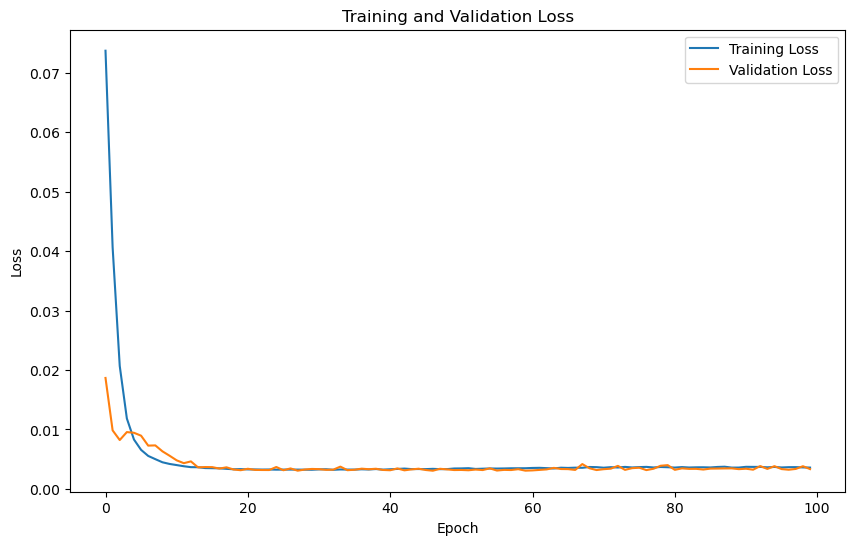

In [12]:
# Plot the loss diagram
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Training and Validation Loss.png', dpi=600, bbox_inches='tight')
plt.show()



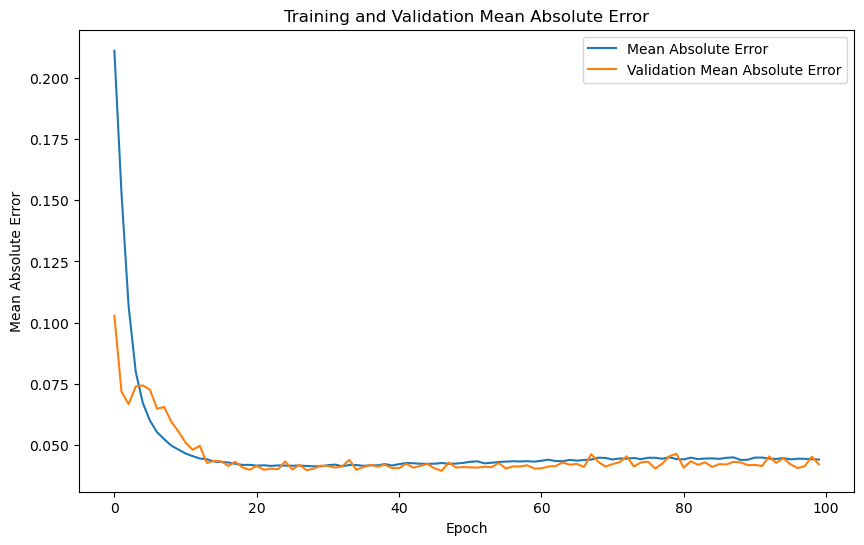

In [13]:
# Plot the accuracy diagram
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Mean Absolute Error')
plt.plot(history.history['val_mae'], label='Validation Mean Absolute Error')
plt.title('Training and Validation Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.savefig('Training and Validation Mean Absolute Error.png', dpi=600, bbox_inches='tight')
plt.show()

In [14]:
min_agb = np.min(agb_values)
max_agb = np.max(agb_values)
print(min_agb)
print(max_agb)

0
306158


In [15]:
y_test_pred = vit_classifier.predict(x_test)
y_pred = y_test_pred * (max_agb - min_agb) + min_agb
y_test2 = y_test * (max_agb - min_agb) + min_agb

In [16]:
r2 = r2_score(y_test2, y_pred)

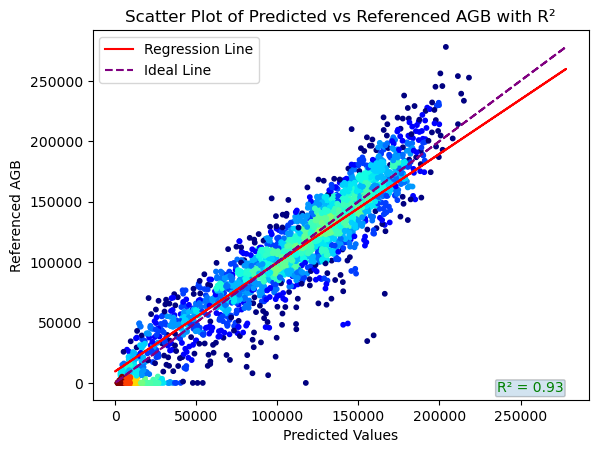

In [18]:
from matplotlib.colors import LogNorm

# Reshape arrays if needed
y_test2 = np.array(y_test2).flatten()
y_pred = np.array(y_pred).flatten()

# Create a 2D histogram to calculate point density
hist, x_edges, y_edges = np.histogram2d(y_test2, y_pred, bins=(50, 50), density=True)

# Calculate the point density for each point
density = hist[np.clip(np.digitize(y_test2, x_edges) - 1, 0, hist.shape[0] - 1),
               np.clip(np.digitize(y_pred, y_edges) - 1, 0, hist.shape[1] - 1)]

# Use logarithmic scaling for density values
log_density = np.log1p(density)

# Scatter plot with color based on log-scaled density and inverse hot colormap
scatter = plt.scatter(y_pred, y_test2, c=log_density, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line
regression_line = np.polyfit(y_test2, y_pred, 1)
poly_y = np.polyval(regression_line, y_test2)
plt.plot(y_test2, poly_y, color='red', label='Regression Line')

# Plot ideal line (y = x)
plt.plot(y_test2, y_test2, color='purple', linestyle='--', label='Ideal Line')

# Annotate R^2 value creatively
annotation_text = f'R² = {r2:.2f}'
plt.annotate(annotation_text, xy=(0.95, 0.05), xycoords='axes fraction',
             fontsize=10, ha='right', va='top', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar
plt.xlabel('Predicted Values')
plt.ylabel('Referenced AGB')
plt.title('Scatter Plot of Predicted vs Referenced AGB with R²')
plt.legend()

# Save the plot as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_density_colored_log_inverse_hot.png', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()





In [19]:
y_train_pred = vit_classifier.predict(x_train)

In [20]:
# Calculate R^2 for training data

y_train_pred2 = y_train_pred * (max_agb - min_agb) + min_agb
y_train2 = y_train * (max_agb - min_agb) + min_agb
# # Flatten the arrays
y_train_pred2_flat = y_train_pred2.flatten()
y_train2_flat = y_train2.flatten()

# Calculate R^2 for training data
r2_train = r2_score(y_train2_flat, y_train_pred2_flat)

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions on training data

y_train_pred = y_train_pred * (max_agb - min_agb) + min_agb  # Denormalize predictions
y_train_denormalized = y_train * (max_agb - min_agb) + min_agb  # Denormalize true values


y_test_pred = y_test_pred * (max_agb - min_agb) + min_agb  # Denormalize predictions
y_test_denormalized = y_test * (max_agb - min_agb) + min_agb  # Denormalize true values

# Calculate metrics for training data
train_rmse = np.sqrt(mean_squared_error(y_train2_flat, y_train_pred2_flat))
train_mae = mean_absolute_error(y_train2_flat, y_train_pred2_flat)
train_r2 = r2_score(y_train2_flat, y_train_pred2_flat)

# Calculate metrics for test data
test_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
test_mae = mean_absolute_error(y_test2, y_pred)
test_r2 = r2_score(y_test2, y_pred)

# Print or use the metrics as needed
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Train R2: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R2: {test_r2:.4f}")

Train RMSE: 16761.6303
Train MAE: 12136.0138
Train R2: 0.9264
Test RMSE: 17002.7349
Test MAE: 12355.3212
Test R2: 0.9257


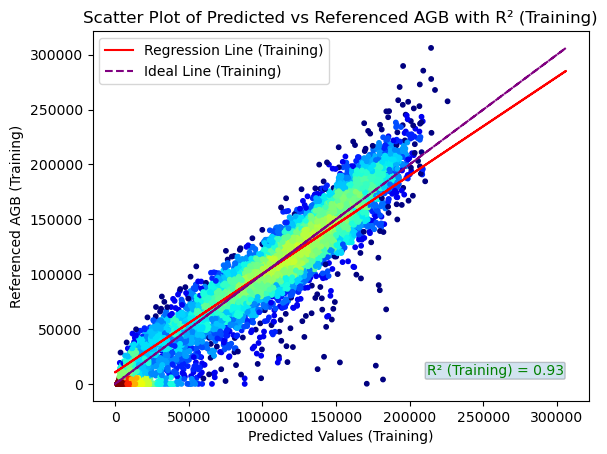

In [22]:
from matplotlib.colors import LogNorm
# Flatten the arrays
y_train_pred2_flat = y_train_pred2.flatten()
y_train2_flat = y_train2.flatten()

# Create a 2D histogram to calculate point density for training data
hist_train, x_edges_train, y_edges_train = np.histogram2d(y_train2_flat, y_train_pred2_flat, bins=(50, 50), density=True)

# Calculate the point density for each point for training data
density_train = hist_train[np.clip(np.digitize(y_train2_flat, x_edges_train) - 1, 0, hist_train.shape[0] - 1),
               np.clip(np.digitize(y_train_pred2_flat, y_edges_train) - 1, 0, hist_train.shape[1] - 1)]

# Use logarithmic scaling for density values for training data
log_density_train = np.log1p(density_train)

# Scatter plot with color based on log-scaled density for training data
scatter_train = plt.scatter(y_train_pred2_flat, y_train2_flat, c=log_density_train, cmap='jet', s=10, norm=LogNorm())

# Plot true regression line for training data
regression_line_train = np.polyfit(y_train2_flat, y_train_pred2_flat, 1)
poly_y_train = np.polyval(regression_line_train, y_train2_flat)
plt.plot(y_train2_flat, poly_y_train, color='red', label='Regression Line (Training)')

# Plot ideal line (y = x) for training data
plt.plot(y_train2_flat, y_train2_flat, color='purple', linestyle='--', label='Ideal Line (Training)')

# Annotate R^2 value creatively for training data
annotation_text_train = f'R² (Training) = {r2_train:.2f}'
plt.annotate(annotation_text_train, xy=(0.95, 0.10), xycoords='axes fraction',
             fontsize=10, ha='right', va='top', color='green', bbox=dict(boxstyle="round,pad=0.1", alpha=0.2))

# Add labels, legend, and colorbar for training data
plt.xlabel('Predicted Values (Training)')
plt.ylabel('Referenced AGB (Training)')
plt.title('Scatter Plot of Predicted vs Referenced AGB with R² (Training)')
plt.legend()

# Save the plot for training data as a high-quality PNG image with smaller points
plt.savefig('scatter_plot_training_data.png', dpi=600, bbox_inches='tight')

# Show the plot for training data
plt.show()